# Initial Setup

## Import Standard packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Import time series data: Airline passenger traffic

In [2]:
data = pd.read_csv('airline-passenger-traffic+(1).csv', header=None)
data.columns = ['Month', 'Passengers']
data['Month'] = pd.to_datetime(data['Month'], format="%Y-%m")
data = data.set_index('Month')
data.head(12)

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
1949-06-01,135.0
1949-07-01,148.0
1949-08-01,148.0
1949-09-01,136.0


# Time Series analysis

## Plot time series data

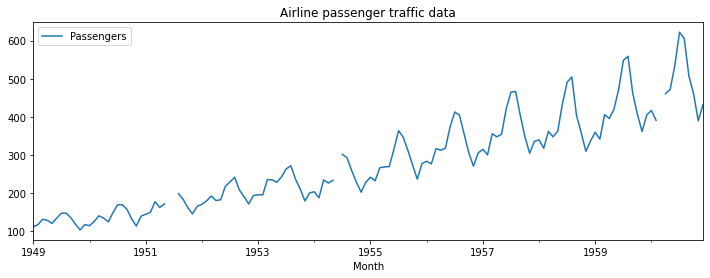

In [3]:
data.plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Airline passenger traffic data')
plt.show(block=False)

## Missing value treatment

### Mean Imputation

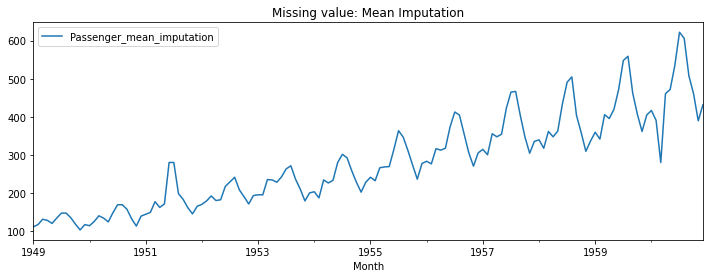

In [4]:
data = data.assign(Passenger_mean_imputation = data.Passengers.fillna(data.Passengers.mean()))
data[['Passenger_mean_imputation']].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Missing value: Mean Imputation')
plt.show(block=False)

### Linear Interpolation

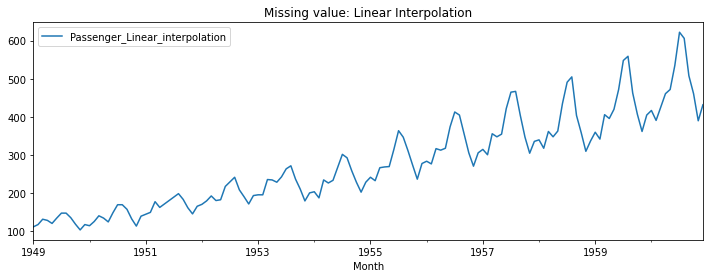

In [5]:
data = data.assign(Passenger_Linear_interpolation = data.Passengers.interpolate(method='linear'))
data[['Passenger_Linear_interpolation']].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('Missing value: Linear Interpolation')
plt.show(block=False)

Use Linear Interpolation to impute missing values

In [6]:
data['Passengers'] = data['Passenger_Linear_interpolation']

## Outlier Detection

### Box plot and interquantile range

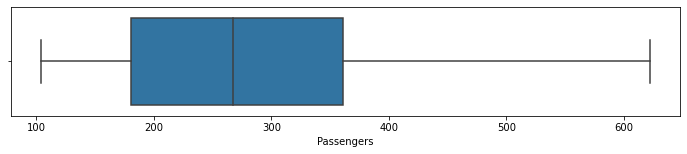

In [7]:
import seaborn as sns
fig = plt.subplots(figsize=(12,2))
ax = sns.boxplot(x=data['Passengers'], whis=1.5) ## IRQ*1.5 + 25th<range< IRQ*1.5 + 75th 

There is not outlier when range of 75th and 25th quantile is multiplied by 1.5 times

### Histogram

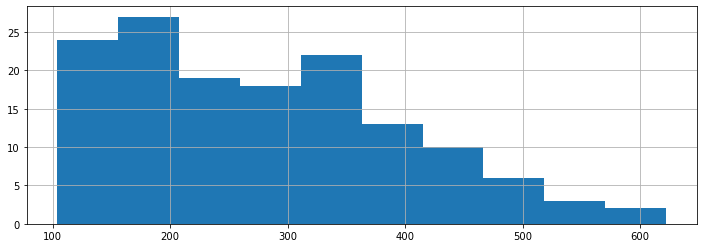

In [8]:
fig = data.Passengers.hist(figsize=(12,4))

## Time series Decomposition

### Additive Seasonal decomposition

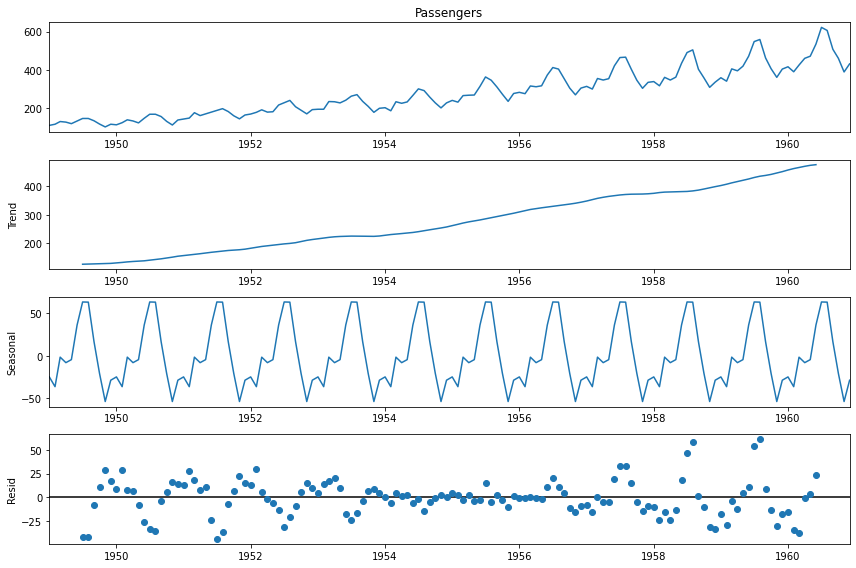

In [9]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12,8
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='additive')
fig = decomposition.plot()
plt.show()

### Multiplicative Seasonal decomposition

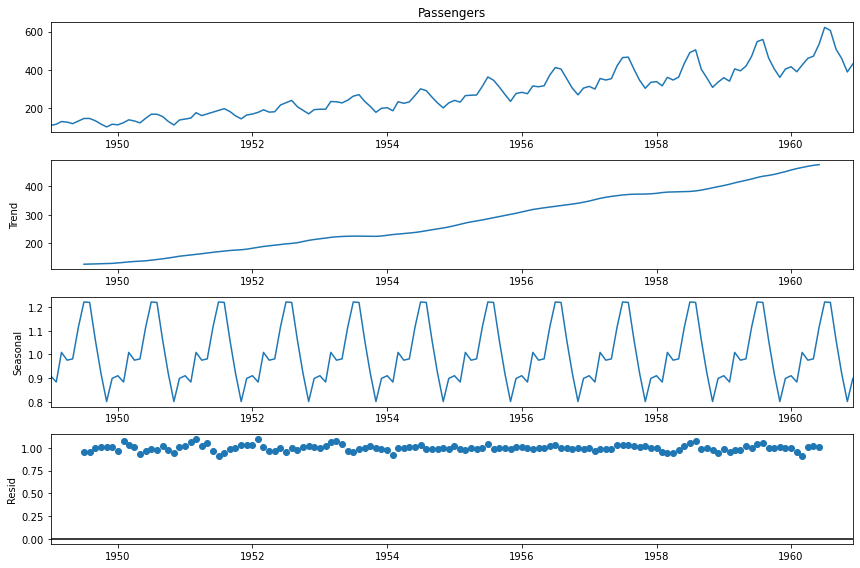

In [10]:
decomposition = sm.tsa.seasonal_decompose(data.Passengers, model='multiplicative')
fig = decomposition.plot()
plt.show()

## Build and evaluate time series forecast

### Splitting time series into Train and Test sets

In [11]:
# Training lenght - first 120 rows of data 
train_len = 120
train = data[0:train_len]
test = data[train_len:]

### Naive Method

In [12]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Passengers'][train_len-1]

#### Plot Train, Test and Forecast

Text(0.5, 1.0, 'Naive Method')

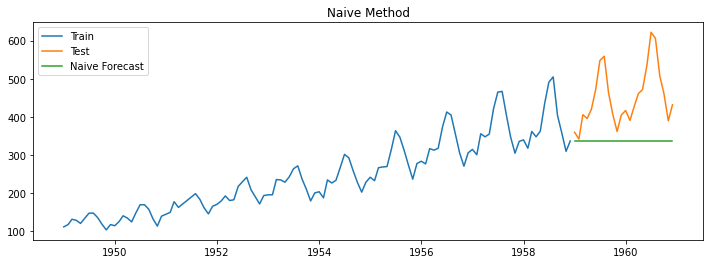

In [13]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive Forecast')
plt.legend(loc='best')
plt.title('Naive Method')

Underforecasting the sales

#### Calculate RMSE and MAPE to evaluate forecast|

In [14]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_naive['naive_forecast'])/test['Passengers'])*100,2)

results = pd.DataFrame({'Method':['Naive method'],'MAPE(%)':[mape],'RMSE':[rmse]})
#results = results[['Method','RMSE','MAPE']]
results

,Method,MAPE(%),RMSE
0,Naive method,23.63,137.51


### Simple Average method

In [15]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast']=train['Passengers'].mean()

#### Plot Train, Test and Forecast

Text(0.5, 1.0, 'Simple Avg Method')

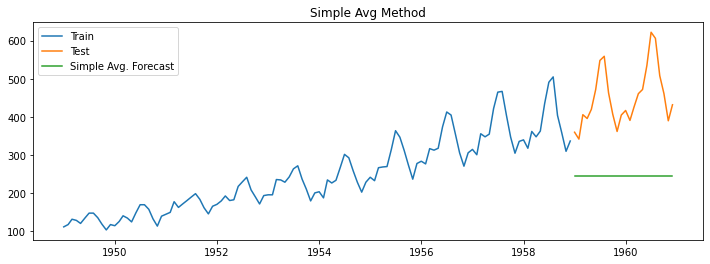

In [16]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple Avg. Forecast')
plt.legend(loc='best')
plt.title('Simple Avg Method')

Underforecasting

#### Calculate RMSE and MAPE to evaluate forecast

In [17]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_avg['avg_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple Avg. Method'],'MAPE(%)':[mape],'RMSE':[rmse]})
results = pd.concat([results,tempResults])
results

,Method,MAPE(%),RMSE
0,Naive method,23.63,137.51
0,Simple Avg. Method,44.28,219.69


### Simple moving average method

In [18]:
y_hat_sma = data.copy() 
#data.copy() is used because in sma we also want to illustrate during training period as wee, if we need to forecast for PAST

ma_window = 12
y_hat_sma['sma_forecast'] = data['Passengers'].rolling(ma_window).mean()

# In actual scenario, for rolling calculation you need to have 12 months data available (our ma_window), so for Dec 1960 you need have data for Dec 1959
# , But in live we will not have any data available as those are part of TEST data (from Jan 1959 onwards).
# So we will set Test range with same forecast as the latest one means Dec 1958

y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]


#### Plot Train, Test and Forecast

Text(0.5, 1.0, 'SMA Method')

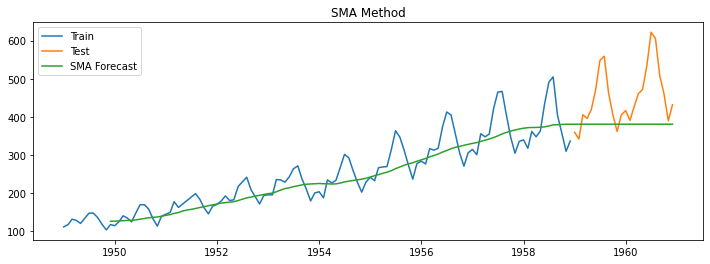

In [19]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='SMA Forecast')
plt.legend(loc='best')
plt.title('SMA Method')

Because we used whole dataset, so forecast is done for Past as well - Green line

#### Calculate RMSE and MAPE to evaluate forecast

In [20]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_sma['sma_forecast'][train_len:])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple Moving Avg. Method'],'MAPE(%)':[mape],'RMSE':[rmse]})
results = pd.concat([results,tempResults])
results

,Method,MAPE(%),RMSE
0,Naive method,23.63,137.51
0,Simple Avg. Method,44.28,219.69
0,Simple Moving Avg. Method,15.54,103.33


**Lets REDUCE the Moving Window and see how it improves the forecast**

In [21]:
y_hat_sma = data.copy() 

ma_window = 3
y_hat_sma['sma_forecast'] = data['Passengers'].rolling(ma_window).mean()

y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]


Text(0.5, 1.0, 'SMA Method')

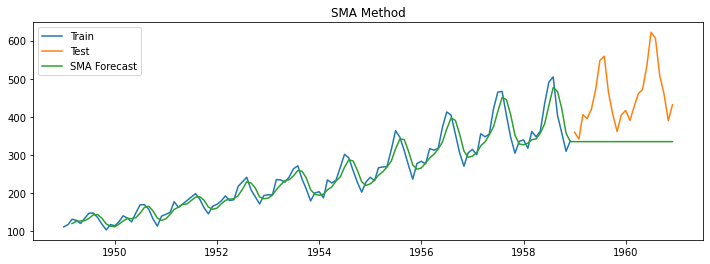

In [22]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='SMA Forecast')
plt.legend(loc='best')
plt.title('SMA Method')

Though we have been able to capture previous/past forecast better but if the window is too small then - 
1. Risk of capturing Noise as well in the data
2. Forecast for TEST/Future has flattend as end of 1958 (Oct, Nov and Dec) (3 months) then Passenger travel is LOW and this is used for all future forecast, which is why line flattend at low forecast.

**Lets HIGHER the Moving Window and see how it affects the forecast**

In [23]:
y_hat_sma = data.copy() 

ma_window = 48
y_hat_sma['sma_forecast'] = data['Passengers'].rolling(ma_window).mean()

y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]



Text(0.5, 1.0, 'SMA Method')

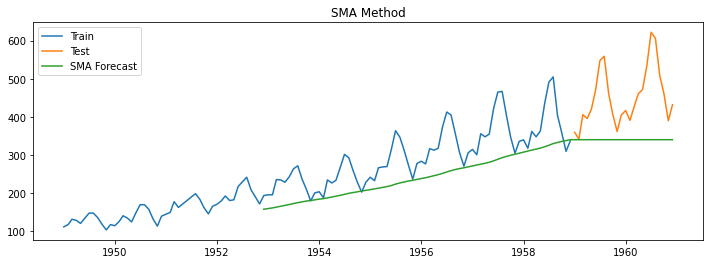

In [24]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='SMA Forecast')
plt.legend(loc='best')
plt.title('SMA Method')

Underpredict due to higher window.
Lets set it back to 12 months

In [25]:
y_hat_sma = data.copy() 

ma_window = 12
y_hat_sma['sma_forecast'] = data['Passengers'].rolling(ma_window).mean()

y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]



Text(0.5, 1.0, 'SMA Method')

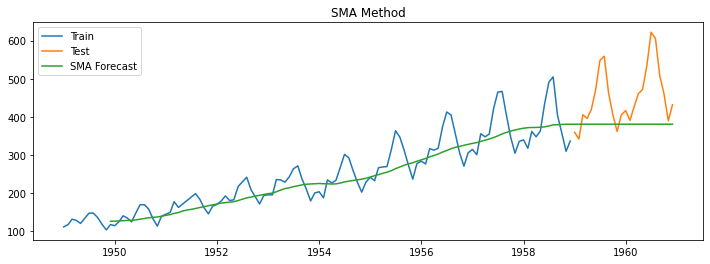

In [26]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='SMA Forecast')
plt.legend(loc='best')
plt.title('SMA Method')

### Simple Exponential Smoothing (SES)

In [27]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Passengers'])
model_fit = model.fit(smoothing_level=0.2, optimized=False)
model_fit.params

y_hat_ses = test.copy()
y_hat_ses['ses'] = model_fit.forecast(24)

/Users/ragnarok09/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


#### Plot Train, Test and Forecast

In [28]:
y_hat_ses['ses'].tail()

Month
1960-08-01    374.897327
1960-09-01    374.897327
1960-10-01    374.897327
1960-11-01    374.897327
1960-12-01    374.897327
Name: ses, dtype: float64

Text(0.5, 1.0, 'SES Method')

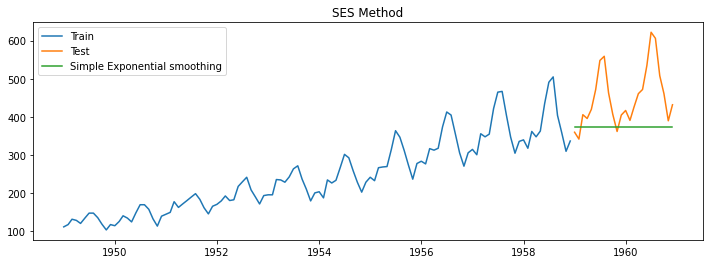

In [29]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_ses['ses'], label='Simple Exponential smoothing')
plt.legend(loc='best')
plt.title('SES Method')

#### Calculate RMSE and MAPE to evaluate forecast

In [30]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_ses['ses'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_ses['ses'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Simple exponential smoothing'],'MAPE(%)':[mape],'RMSE':[rmse]})
results = pd.concat([results,tempResults])
results

,Method,MAPE(%),RMSE
0,Naive method,23.63,137.51
0,Simple Avg. Method,44.28,219.69
0,Simple Moving Avg. Method,15.54,103.33
0,Simple exponential smoothing,16.49,107.65


### Holt's Exponential Smoothing

In [31]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['Passengers']), 
                             seasonal_periods=12, trend='additive')
model_fit=model.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.2, 'smoothing_trend': 0.01, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 112.0, 'initial_trend': 6.0, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


#### Plot Train, Test and Forecast

Text(0.5, 1.0, "Holt's Exponential Smooting Method")

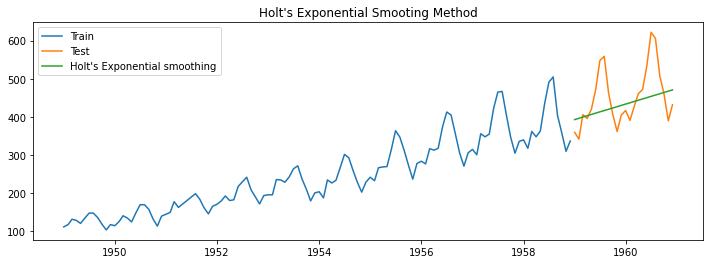

In [32]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s Exponential smoothing')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smooting Method')

#### Calculate RMSE and MAPE to evaluate forecast

In [33]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_holt['holt_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing'],'MAPE(%)':[mape],'RMSE':[rmse]})
results = pd.concat([results,tempResults])
results

,Method,MAPE(%),RMSE
0,Naive method,23.63,137.51
0,Simple Avg. Method,44.28,219.69
0,Simple Moving Avg. Method,15.54,103.33
0,Simple exponential smoothing,16.49,107.65
0,Holt's exponential smoothing,11.11,71.94


### Holt's Winter Additive with Trend and Seasonality

In [34]:
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers']), 
                             seasonal_periods=12, trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)

y_hat_hwa = test.copy()
y_hat_hwa['holt_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.23610842590351697, 'smoothing_trend': 6.970126695752153e-10, 'smoothing_seasonal': 0.7638915708143837, 'damping_trend': nan, 'initial_level': 205.01335392470932, 'initial_trend': 2.276753226434782, 'initial_seasons': array([ -95.30780357,  -89.77605643,  -77.25808484,  -82.34584342,
        -91.04295952,  -76.89614849,  -64.63077217,  -66.55221739,
        -80.64360522,  -99.4936058 , -114.17413116,  -98.01818086]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


#### Plot Train, Test and Forecast

Text(0.5, 1.0, "Holt's Winters Exponential Smooting Method")

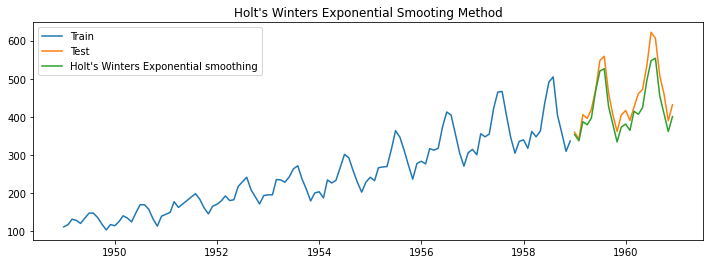

In [35]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_hwa['holt_forecast'], label='Holt\'s Winters Exponential smoothing')
plt.legend(loc='best')
plt.title('Holt\'s Winters Exponential Smooting Method')

#### Calculate RMSE and MAPE to evaluate forecast

In [36]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwa['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_hwa['holt_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s Winters add exponential smoothing'],'MAPE(%)':[mape],'RMSE':[rmse]})
results = pd.concat([results,tempResults])
results

,Method,MAPE(%),RMSE
0,Naive method,23.63,137.51
0,Simple Avg. Method,44.28,219.69
0,Simple Moving Avg. Method,15.54,103.33
0,Simple exponential smoothing,16.49,107.65
0,Holt's exponential smoothing,11.11,71.94
0,Holt's Winters add exponential smoothing,6.72,35.87


### Holt's Winter Multiplicative with Trend and Seasonality

In [37]:
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['Passengers']), 
                             seasonal_periods=12, trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)

y_hat_hwm['hwm_forecast'] = model_fit.forecast(24)

{'smoothing_level': 0.3655890122229721, 'smoothing_trend': 1.8844605281966404e-09, 'smoothing_seasonal': 0.6344109872708108, 'damping_trend': nan, 'initial_level': 181.46075583828218, 'initial_trend': 3.9303119567973055, 'initial_seasons': array([0.60412204, 0.63546104, 0.69845435, 0.66401646, 0.61289203,
       0.67023314, 0.72884607, 0.7239085 , 0.66033988, 0.57545766,
       0.51158411, 0.59022751]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


#### Plot Train, Test and Forecast

Text(0.5, 1.0, "Holt's Winters Multi Exponential Smooting Method")

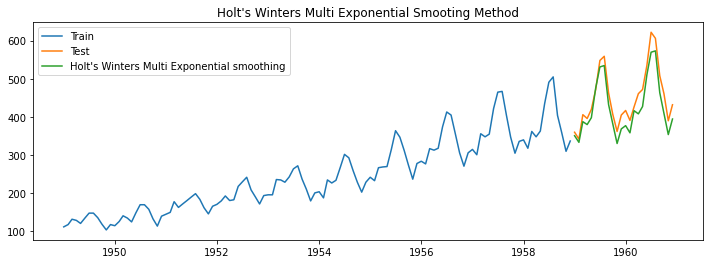

In [38]:
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_hwm['hwm_forecast'], label='Holt\'s Winters Multi Exponential smoothing')
plt.legend(loc='best')
plt.title('Holt\'s Winters Multi Exponential Smooting Method')

#### Calculate RMSE and MAPE to evaluate forecast

In [39]:
rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwm['hwm_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_hwm['hwm_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s Winters Mult exponential smoothing'],'MAPE(%)':[mape],'RMSE':[rmse]})
results = pd.concat([results,tempResults])
results

,Method,MAPE(%),RMSE
0,Naive method,23.63,137.51
0,Simple Avg. Method,44.28,219.69
0,Simple Moving Avg. Method,15.54,103.33
0,Simple exponential smoothing,16.49,107.65
0,Holt's exponential smoothing,11.11,71.94
0,Holt's Winters add exponential smoothing,6.72,35.87
0,Holt's Winters Mult exponential smoothing,6.45,32.45


,Method,MAPE(%),RMSE
0,Naive method,23.63,137.51
0,Simple Avg. Method,44.28,219.69
0,Simple Moving Avg. Method,15.54,103.33
0,Simple exponential smoothing,16.49,107.65
0,Holt's exponential smoothing,11.11,71.94
0,Holt's Winters add exponential smoothing,6.72,35.87
0,Holt's Winters Mult exponential smoothing,6.45,32.45
0,Holt's exponential smoothing,6.72,35.87


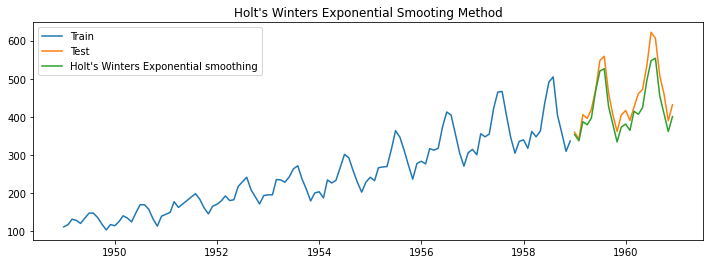

In [40]:
#### Plot Train, Test and Forecast

plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test['Passengers'], label='Test')
plt.plot(y_hat_hwa['holt_forecast'], label='Holt\'s Winters Exponential smoothing')
plt.legend(loc='best')
plt.title('Holt\'s Winters Exponential Smooting Method')

#### Calculate RMSE and MAPE to evaluate forecast

rmse = np.sqrt(mean_squared_error(test['Passengers'], y_hat_hwa['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Passengers'] - y_hat_hwa['holt_forecast'])/test['Passengers'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing'],'MAPE(%)':[mape],'RMSE':[rmse]})
results = pd.concat([results,tempResults])
results